<a href="https://colab.research.google.com/github/fmuranda/Climate_Science./blob/main/tutorials/W2D4_AIandClimateChange/student/W2D4_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D4_AIandClimateChange/student/W2D4_Tutorial4.ipynb)   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D4_AIandClimateChange/student/W2D4_Tutorial4.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 4: Testing Spatial Generalization

**Week 2, Day 4, AI and Climate Change**

**Content creators:**  Deepak Mewada, Grace Lindsay

**Content reviewers:** Mujeeb Abdulfatai, Nkongho Ayuketang Arreyndip, Jeffrey N. A. Aryee, Paul Heubel, Jenna Pearson, Abel Shibu

**Content editors:** Deepak Mewada, Grace Lindsay

**Production editors:** Paul Heubel, Konstantine Tsafatinos

**Our 2024 Sponsors:** CMIP, NFDI4Earth

# Tutorial Objectives

*Estimated timing of tutorial:* 20 minutes

In this tutorial, you will:   
* Learn the concept of within distribution generalization
* Test your model’s ability on a certain type of out-of-distribution data


# Setup

In [1]:
# for Google Colab users uncomment this install line
!pip install cartopy

# imports:

import matplotlib.pyplot as plt     # For plotting graphs
import pandas as pd                 # For data manipulation
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import specific machine learning models and tools
from sklearn.model_selection import train_test_split      # For splitting dataset into train and test sets
from sklearn.ensemble import RandomForestRegressor        # For Random Forest Regression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 89.2 MB/s eta 0:00:00


In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "comptools_4clim",
            "user_key": "l5jpxuee",
        },
    ).render()


feedback_prefix = "W2D4_T4"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00


In [3]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

In [4]:
# @title Helper functions

# Load and Prepare the Data
url_Climatebench_train_val = "https://osf.io/y2pq7/download"  # Dataset URL
training_data = pd.read_csv(url_Climatebench_train_val)  # Load the training data from the provided URL
training_data.pop('scenario')  # Drop the 'scenario' column as it's just a label and won't be passed into the model
target = training_data.pop('tas_FINAL')  # Extract the target variable 'tas_FINAL' which we aim to predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_data, target, test_size=0.2, random_state=1)

In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import numpy as np

def set_seed(seed=None):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    print(f'Random seed {seed} has been set.')

# Set a global seed value for reproducibility
random_state = 42 # change 42 with any number you like

set_seed(seed=random_state)

Random seed 42 has been set.


In [6]:
# @title Plotting functions
# @markdown Run this cell to define plotting function we will be using in this code

def visualize_decision_tree(X_train, y_train, X_test, y_test, dt_model):
    # Plot decision tree and regression
    plt.figure(figsize=(10, 5))

    # Plot Decision Tree
    plt.subplot(1, 2, 1)
    plt.scatter(X_train, y_train, color='blue', label='Training data')
    plt.scatter(X_test, y_test, color='green', label='Test data')
    plt.plot(np.sort(X_test, axis=0), dt_model.predict(np.sort(X_test, axis=0)), color='red', label='Model')
    plt.title('Decision Tree Regression')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()

    # Plot Decision Tree
    plt.subplot(1, 2, 2)
    plot_tree(dt_model, filled=True)
    plt.title("Decision Tree")

    plt.tight_layout()
    plt.show()

def visualize_random_forest(X_train, y_train, X_test, y_test, rf_model):
    num_trees = len(rf_model.estimators_)
    num_cols = min(3, num_trees)
    num_rows = (num_trees + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 6 * num_rows))

    # Plot Random Forest Regression
    plt.subplot(num_rows, num_cols, 1)
    plt.scatter(X_train, y_train, color='blue', label='Training data')
    plt.scatter(X_test, y_test, color='green', label='Test data')
    plt.plot(np.sort(X_test, axis=0), rf_model.predict(np.sort(X_test, axis=0)), color='red', label='Model')
    plt.title('Random Forest Regression')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()

    # Plot Decision Trees within Random Forest
    for i, tree in enumerate(rf_model.estimators_):
        plt.subplot(num_rows, num_cols, i + 2)
        plot_tree(tree, filled=True)
        plt.title(f"Tree {i+1}")

    plt.tight_layout()
    plt.show()

def plot_spatial_distribution(data, col_name, c_label):
    """
    Plot the spatial distribution of a variable of interest.

    Args:
        data (DataFrame): DataFrame containing latitude, longitude, and data of interest.
        col_name (str): Name of the column containing data of interest.
        c_label (str): Label to describe quantity and unit for the colorbar labeling.

    Returns:
        None
    """
    # create a xarray dataset from the pandas dataframe
    # for convenient plotting with cartopy afterwards
    ds = xr.Dataset({col_name: ('points', data[col_name])},
                    coords={'lon': ('points', data['lon']),
                            'lat': ('points', data['lat'])}
                   )

    # create geoaxes
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([0.95*min(ds.lon.values), 1.05*max(ds.lon.values), 0.95*min(ds.lat.values), 1.05*max(ds.lat.values)])

    # add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN, alpha=0.1)
    # add state borders
    ax.add_feature(cfeature.BORDERS, edgecolor='darkgrey')

    # plot the data
    p = ax.scatter(ds['lon'], ds['lat'], c=ds[col_name], cmap='coolwarm', transform=ccrs.PlateCarree())

    # add a colorbar
    cbar = plt.colorbar(p, orientation='vertical')
    cbar.set_label(c_label)

    # add a grid and labels
    ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

    # add title
    plt.title('Spatial Distribution of\n Annual Mean Anomalies\n')
    plt.show()

In [7]:
# @title Video 1: Testing spatial generalization

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
    def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
        self.id = id
        if source == 'Bilibili':
            src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
        elif source == 'Osf':
            src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
        super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
    tab_contents = []
    for i, video_id in enumerate(video_ids):
        out = widgets.Output()
        with out:
            if video_ids[i][0] == "Youtube":
                video = YouTubeVideo(
                    id=video_ids[i][1], width=W, height=H, fs=fs, rel=0
                )
                print(f"Video available at https://youtube.com/watch?v={video.id}")
            else:
                video = PlayVideo(
                    id=video_ids[i][1],
                    source=video_ids[i][0],
                    width=W,
                    height=H,
                    fs=fs,
                    autoplay=False,
                )
                if video_ids[i][0] == "Bilibili":
                    print(
                        f"Video available at https://www.bilibili.com/video/{video.id}"
                    )
                elif video_ids[i][0] == "Osf":
                    print(f"Video available at https://osf.io/{video.id}")
            display(video)
        tab_contents.append(out)
    return tab_contents

video_ids = [('Youtube', 'K21IxbNGTKw'), ('Bilibili', 'BV1dwGDeoEeo'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
    tabs.set_title(i, video_ids[i][0])
display(tabs)

In [8]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Testing_model_generalization_Video")

In [9]:
# @title Tutorial slides

# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "26r8h"

print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/26r8h/


In [10]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Testing_model_generalization_Slides")

In the video, we discussed how we previously tested generalization to unseen data points from the same data distribution (i.e., same region and scenarios).
Now we will see if the model generalizes to data from a new region.



# Section 1:  Test generalization to held-out spatial locations

## Section 1.1: Load the New Testing Data

We will take our random forest model that was trained on data from the region in the blue box and see if it can work well using lat/lon locations that come from the red box. We already have the data from the blue box region loaded, so now we just need to load the data from the red box.

<p align='center'><img src='https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W2D4_AIandClimateChange/images/W2D4_Tutorial4_map.png?raw=True' alt='W2D4_Tutorial4_map'/></p>

In [20]:
# Loading the new Spatial test data

url_spatial_test_data = "https://osf.io/7tr49/download" # location of test data
spatial_test_data = pd.read_csv(url_spatial_test_data)  # Load spatial test data from the provided URL
spatial_test_data.pop('scenario')  # drop the `scenario` column from the data as it is just a label, but will not be passed into the model.
spatial_test_target = spatial_test_data.pop('tas_FINAL')  # extract the target variable 'tas_FINAL'
# display the prepared spatial test data
spatial_test_data

,lat,lon,tas_2015,pr_2015,pr90_2015,dtr_2015,CO2_2015,SO2_2015,CH4_2015,BC_2015,...,CH4_2048,BC_2048,CO2_2049,SO2_2049,CH4_2049,BC_2049,CO2_2050,SO2_2050,CH4_2050,BC_2050
0,31.263158,47.5,1.434113,-2.025640e-06,-1.509236e-06,-0.179675,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
1,31.263158,50.0,1.620880,-2.852703e-06,-5.734659e-06,0.047719,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
2,31.263158,52.5,1.749939,-2.216529e-06,-7.738655e-06,0.275297,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
3,31.263158,55.0,1.975800,-1.224600e-06,-4.887234e-06,-0.052649,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
4,31.263158,57.5,1.921234,-9.459098e-07,-3.401928e-06,-0.133629,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,44.526316,57.5,1.708333,4.798176e-08,-1.938347e-07,-0.160063,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.530093,2.932431e-09,3231.101144,2.975203e-08,0.534263,2.840629e-09,3291.118087,2.854076e-08,0.538434,2.748826e-09
284,44.526316,60.0,1.771372,-1.988004e-09,-5.014728e-07,-0.194233,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.530093,2.932431e-09,3231.101144,2.975203e-08,0.534263,2.840629e-09,3291.118087,2.854076e-08,0.538434,2.748826e-09
285,44.526316,62.5,1.868540,2.539734e-07,5.819716e-07,-0.209741,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.530093,2.932431e-09,3231.101144,2.975203e-08,0.534263,2.840629e-09,3291.118087,2.854076e-08,0.538434,2.748826e-09
286,44.526316,65.0,1.873759,3.921430e-07,2.444069e-06,-0.185773,1536.072222,6.686393e-08,0.373737,5.090832e-09,...,0.530093,2.932431e-09,3231.101144,2.975203e-08,0.534263,2.840629e-09,3291.118087,2.854076e-08,0.538434,2.748826e-09


from matplotlib import pyplot as plt
spatial_test_data['lat'].plot(kind='hist', bins=20, title='lat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data['lon'].plot(kind='hist', bins=20, title='lon')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data['tas_2015'].plot(kind='hist', bins=20, title='tas_2015')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data['pr_2015'].plot(kind='hist', bins=20, title='pr_2015')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data.plot(kind='scatter', x='lat', y='lon', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data.plot(kind='scatter', x='lon', y='tas_2015', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data.plot(kind='scatter', x='tas_2015', y='pr_2015', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data.plot(kind='scatter', x='pr_2015', y='pr90_2015', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CO2_2015']
  ys = series['lat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = spatial_test_data.sort_values('CO2_2015', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CO2_2015')
_ = plt.ylabel('lat')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CO2_2015']
  ys = series['lon']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = spatial_test_data.sort_values('CO2_2015', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CO2_2015')
_ = plt.ylabel('lon')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CO2_2015']
  ys = series['tas_2015']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = spatial_test_data.sort_values('CO2_2015', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CO2_2015')
_ = plt.ylabel('tas_2015')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CO2_2015']
  ys = series['pr_2015']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = spatial_test_data.sort_values('CO2_2015', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CO2_2015')
_ = plt.ylabel('pr_2015')

from matplotlib import pyplot as plt
spatial_test_data['lat'].plot(kind='line', figsize=(8, 4), title='lat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data['lon'].plot(kind='line', figsize=(8, 4), title='lon')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data['tas_2015'].plot(kind='line', figsize=(8, 4), title='tas_2015')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
spatial_test_data['pr_2015'].plot(kind='line', figsize=(8, 4), title='pr_2015')
plt.gca().spines[['top', 'right']].set_visible(False)

When we plot the temperature distribution over space, we can see that this dataset has a different range of latitude and longitude values than the initial dataset. We use a plotting function `plot_spatial_distribution()` that you completed in Coding Exercise 1.4 of Tutorial 1 that can be found in the *plotting function* of the Setup section.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


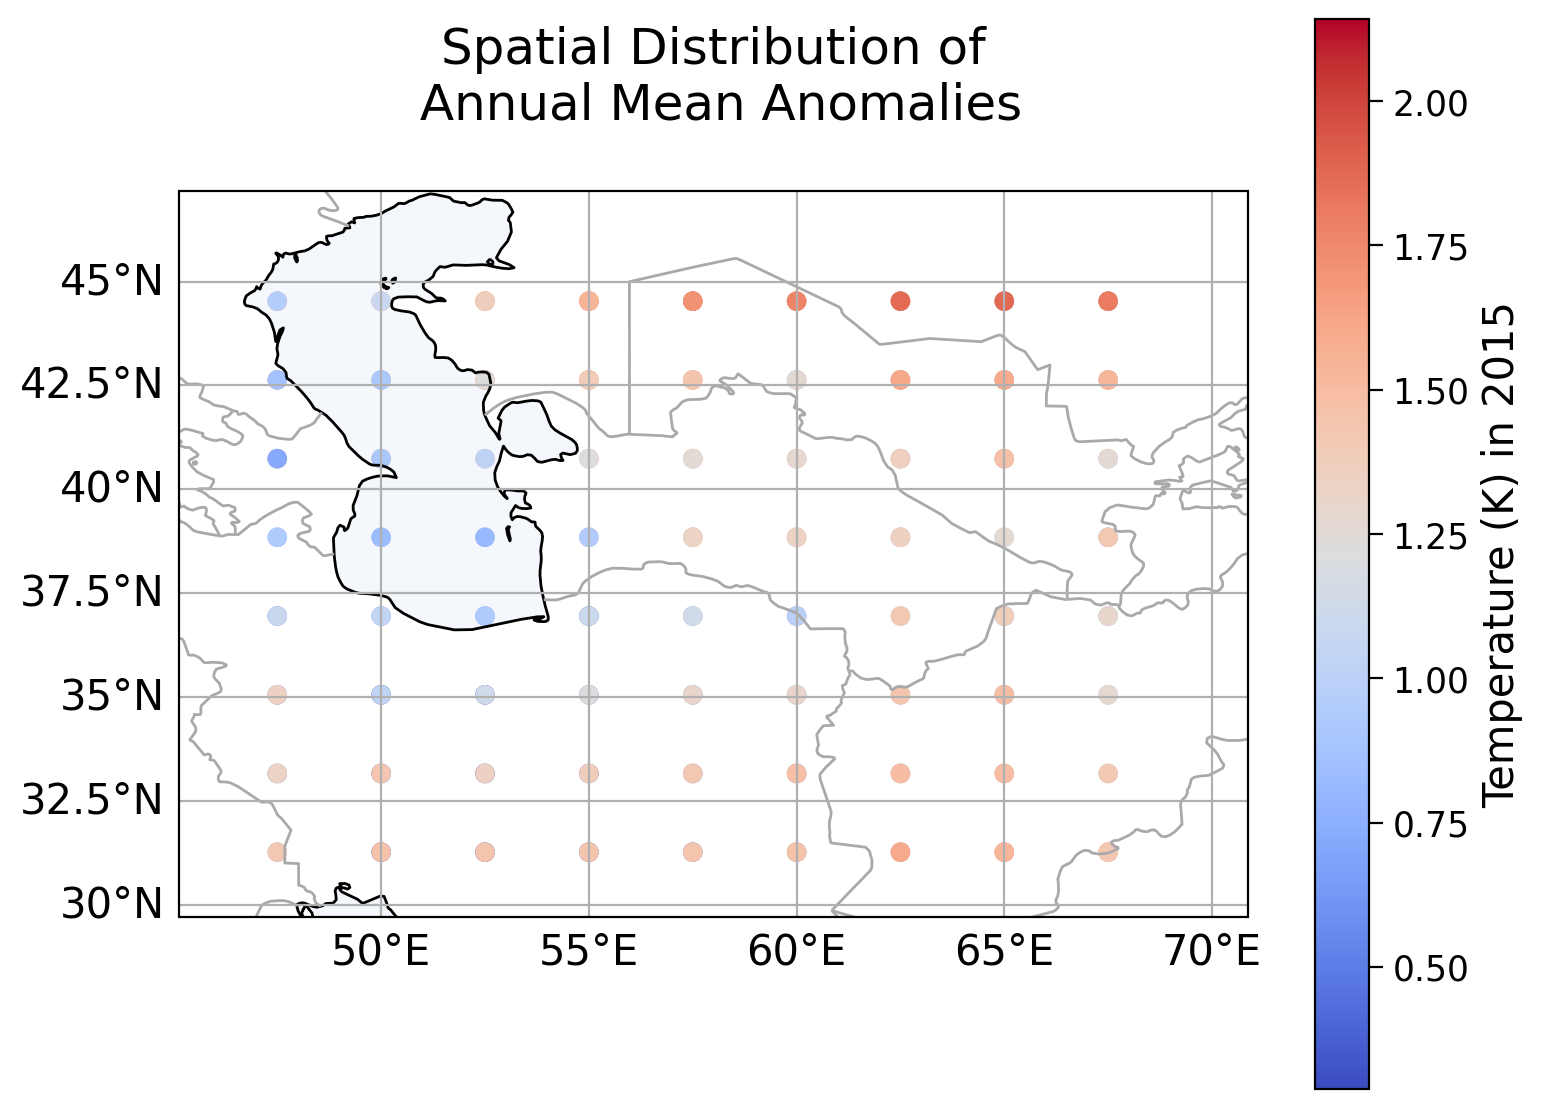

In [12]:
# plot spatial distribution of temperature anomalies for 2015
col_name = 'tas_2015'
c_label = 'Temperature (K) in 2015'
plot_spatial_distribution(spatial_test_data, col_name, c_label)

## Section 1.2: Evaluate the model

We've been playing around with the random forest model parameters. To make sure we know what model we are evaluating, let's train it again here on the training data specifically with `n_estimators = 80` and `max_depth = 50`.

In [13]:
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=80, max_depth=50)
# Train the model on the training data
rf_regressor.fit(X_train, y_train)
train_score = rf_regressor.score(X_train,y_train)
test_score = rf_regressor.score(X_test,y_test)
print( "Training Set Score     : ", train_score)
print( "   Test  Set Score     : ", test_score)

Training Set Score     :  0.9905995322600848
   Test  Set Score     :  0.9280672746455216


Now that the model has been trained on data from the blue box region, let's test how well it performs on data from the red box region

In [14]:
spatial_test_score = rf_regressor.score(spatial_test_data,spatial_test_target)
print( "Spatial Test Data Score : ", spatial_test_score)

Spatial Test Data Score :  0.5472680288793538


Now it is your turn: Make a scatter plot of the predicted vs true 2050 temperature values for this data, like you did in the last tutorials.

### Coding Exercise 1.2: Scatter Plot for Spatial data

In this exercise implement the `scatter_plot_predicted_vs_true()` function to evaluate the performance of a pre-trained Random Forest regressor model on a new emissions scenario and create a scatter plot of predicted vs. true temperature values.


Spatial Test Data Score: 0.5472680288793538


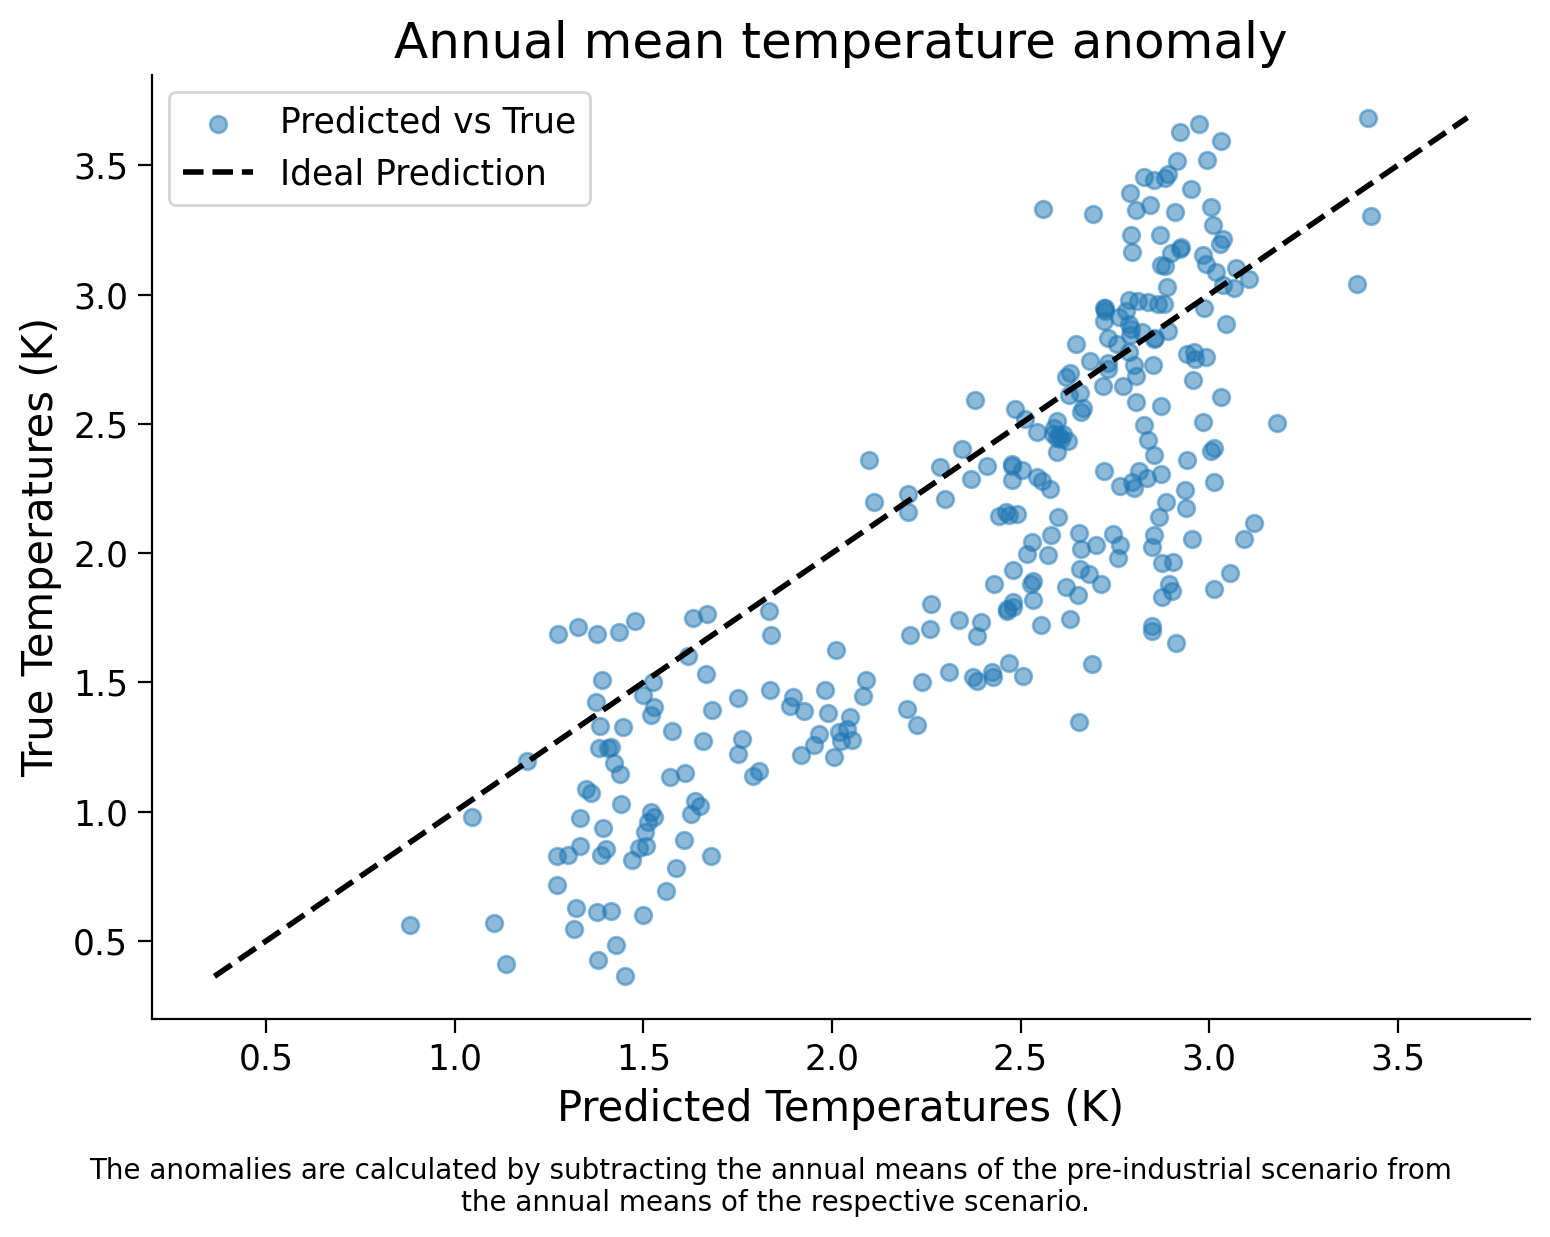

In [18]:
def scatter_plot_predicted_vs_true(spatial_test_data, true_values):
    """Create a scatter plot of predicted vs true temperature values.

    Args:
        spatial_test_data: Test features.
        true_values (ndarray): True temperature values.

    Returns:
        None
    """

    # make predictions using the random forest regressor
    spatial_test_predicted = rf_regressor.predict(spatial_test_data)

    spatial_test_score = rf_regressor.score(spatial_test_data, true_values)
    print("\nSpatial Test Data Score:", spatial_test_score)

    # implement plt.scatter() to compare predicted and true temperature values
    plt.scatter(spatial_test_predicted, true_values, alpha=0.5, label='Predicted vs True')
    # implement plt.plot() to plot the diagonal line y=x
    plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2, label='Ideal Prediction')


    # aesthetics
    plt.xlabel('Predicted Temperatures (K)')
    plt.ylabel('True Temperatures (K)')
    plt.title('Annual mean temperature anomaly')

    # add a caption with adjusted y-coordinate to create space
    caption_text = 'The anomalies are calculated by subtracting the annual means of the pre-industrial scenario from \nthe annual means of the respective scenario.'
    plt.figtext(0.5, -0.03, caption_text, ha='center', fontsize=10)  # Adjusted y-coordinate to create space
    plt.legend(loc='upper left')
    plt.show()

# test your function
_ = scatter_plot_predicted_vs_true(spatial_test_data,spatial_test_target)


Spatial Test Data Score: 0.5472680288793538


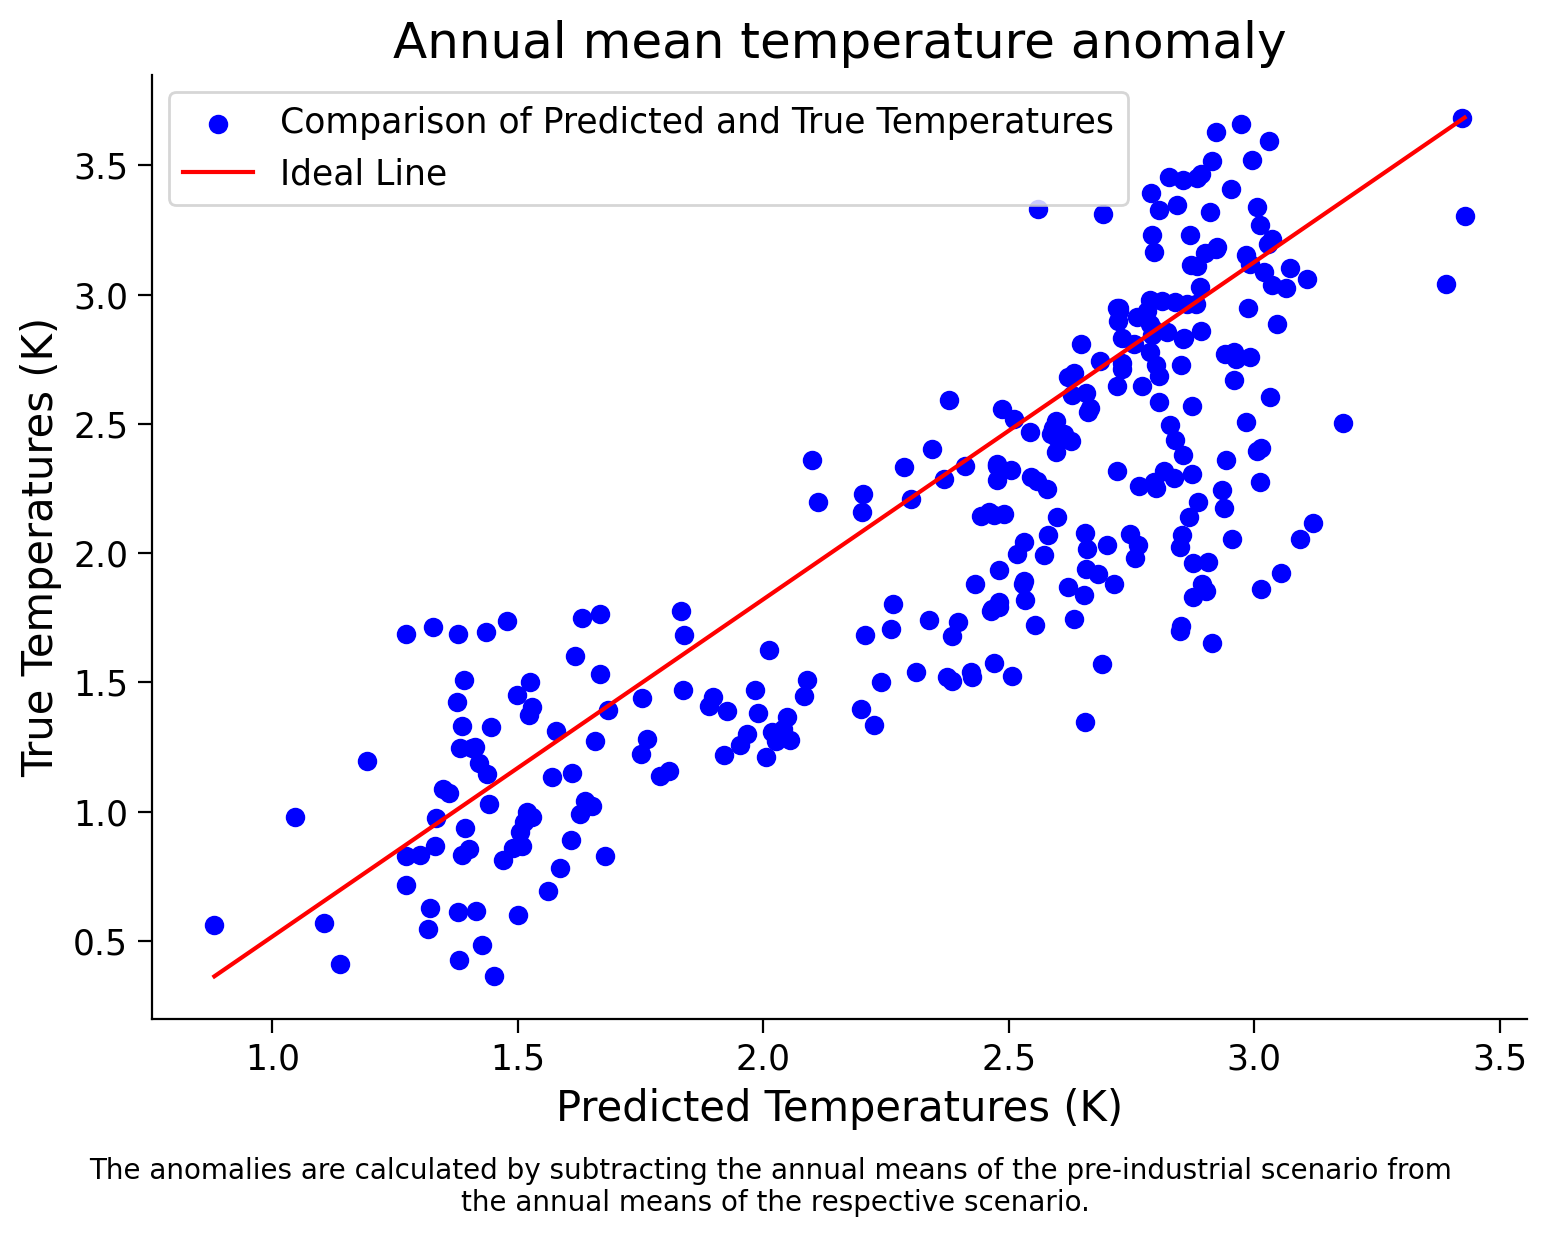

In [19]:
def scatter_plot_predicted_vs_true(spatial_test_data, true_values):
    """Create a scatter plot of predicted vs true temperature values.

    Args:
        spatial_test_data: Test features.
        true_values (ndarray): True temperature values.

    Returns:
        None
    """

    # make predictions using the random forest regressor
    spatial_test_predicted = rf_regressor.predict(spatial_test_data)

    spatial_test_score = rf_regressor.score(spatial_test_data, true_values)
    print("\nSpatial Test Data Score:", spatial_test_score)

    # implement plt.scatter() to compare predicted and true temperature values
    _ = plt.scatter(spatial_test_predicted, true_values, color='b', label='Comparison of Predicted and True Temperatures')
    # implement plt.plot() to plot the diagonal line y=x
    _ = plt.plot([min(spatial_test_predicted), max(spatial_test_predicted)], [min(true_values), max(true_values)], color='r', label='Ideal Line')

    # aesthetics
    plt.xlabel('Predicted Temperatures (K)')
    plt.ylabel('True Temperatures (K)')
    plt.title('Annual mean temperature anomaly')

    # add a caption with adjusted y-coordinate to create space
    caption_text = 'The anomalies are calculated by subtracting the annual means of the pre-industrial scenario from \nthe annual means of the respective scenario.'
    plt.figtext(0.5, -0.03, caption_text, ha='center', fontsize=10)  # Adjusted y-coordinate to create space
    plt.legend(loc='upper left')
    plt.show()

# test your function
_ = scatter_plot_predicted_vs_true(spatial_test_data,spatial_test_target)

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D4_AIandClimateChange/solutions/W2D4_Tutorial4_Solution_a66d4b87.py)

*Example output:*

<img alt='Solution hint' align='left' width=773.0 height=618.0 src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D4_AIandClimateChange/static/W2D4_Tutorial4_Solution_a66d4b87_1.png>



In [16]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_Exercise_1_2")

### Question 1.2: Performance of the model for new spatial location data

1. Have you observed the decrease in score?   
2. What do you believe could be the cause of this?   
3. What do you think would happen if the model was tested on an even farther away region, for example, in North America?

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D4_AIandClimateChange/solutions/W2D4_Tutorial4_Solution_00900b53.py)



In [17]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_1_2")

# Summary

In this tutorial, you investigated the generalization capacity of machine learning models to novel geographical regions. The process involved assessing model performance on spatial datasets from diverse locations, shedding light on the model's adaptability across varying environmental contexts.


# Resources

* [ClimateBench v1.0: A Benchmark for Data-Driven Climate Projections](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002954)
